# 공기청정기 효용상태 분류 및 시각화

## 데이터 전처리 및 오염 범주 분류

In [34]:
import pandas as pd

# CSV 파일 로드
file_path_1 = './dataset/서울교통공사_지하역사 승강장 공기청정기 설치 정보_20230320.csv'
file_path_2 = './dataset/지하역사_공기질_승하차_정보_예측.csv'

data_1 = pd.read_csv(file_path_1)
data_2 = pd.read_csv(file_path_2)

# 숫자형으로 변환, 변환 오류 발생 시 NaN 처리 후 0으로 채움
data_2['미세먼지'] = pd.to_numeric(data_2['미세먼지'], errors='coerce').fillna(0)
data_2['총 승객수'] = pd.to_numeric(data_2['총 승객수'], errors='coerce').fillna(0)

# 두 데이터프레임을 '역명' 열을 기준으로 병합
merged_data = pd.merge(data_1, data_2, on='역명')

# '연도' 컬럼 삭제
merged_data = merged_data.drop(columns=['연도'])

# 중복된 '역명'에 대해 첫 번째 행만 남기기
merged_data = merged_data.drop_duplicates(subset=['역명'], keep='first')

# 오염 등급 정의
def classify_pm10_level(pm10):
    if pm10 >= 100:
        return 3  # 기준치 초과
    elif pm10 >= 85:
        return 2  # 위험
    elif pm10 >= 70:
        return 1  # 보통
    else:
        return 0  # 안전

# 오염 등급을 데이터에 적용
merged_data['오염_등급'] = merged_data['미세먼지'].apply(classify_pm10_level)

# PM10과 총 승객수를 고려한 오염 점수 계산
merged_data['오염_점수'] = 0.6 * merged_data['미세먼지'] + 0.4 * (merged_data['총 승객수'] / merged_data['총 승객수'].max() * 100)

# 오염 점수와 공기청정기 설치 대수의 비율 계산
merged_data['오염_청정기_비율'] = merged_data['오염_점수'] / merged_data['설치대수']

# 오염 비율의 경계값 설정
boundaries = {
    '심각한 과잉': 2.0,
    '과잉': 3.0,
    '적합': 4.0,
    '부족': 5.0,
    '심각한 부족': float('inf')
}

# '오염_청정기_비율'을 기준으로 범주 분류
def classify_efficiency_ratio(ratio):
    if ratio <= boundaries['심각한 과잉']:
        return '심각한 과잉'
    elif ratio <= boundaries['과잉']:
        return '과잉'
    elif ratio <= boundaries['적합']:
        return '적합'
    elif ratio <= boundaries['부족']:
        return '부족'
    else:
        return '심각한 부족'

merged_data['공기청정기_효용_상태'] = merged_data['오염_청정기_비율'].apply(classify_efficiency_ratio)

# 컬럼 순서 변경
cols = ['역명', '공기청정기_효용_상태', '오염_청정기_비율', '오염_점수', '오염_등급', '미세먼지', '설치대수', '총 승객수']
merged_data = merged_data[cols]

# 결과 출력 및 저장
merged_data.to_csv('공기청정기_효용상태.csv', index=False, encoding='utf-8-sig')
print(merged_data[['역명', '공기청정기_효용_상태', '오염_청정기_비율', '오염_점수', '오염_등급', '미세먼지', '설치대수', '총 승객수']])


          역명 공기청정기_효용_상태  오염_청정기_비율      오염_점수  오염_등급   미세먼지  설치대수     총 승객수
0         서울          부족   4.582095  73.313521      2   86.9    16  137657.0
12        시청          과잉   2.923062  70.153491      3  102.0    24   58210.0
25        종각          적합   3.798586  60.777375      1   79.4    16   85411.0
32       동대문          적합   3.951037  63.216590      2   89.4    16   62261.0
45       동묘앞          과잉   2.399890  62.397142      2   93.6    26   40550.0
...      ...         ...        ...        ...    ...    ...   ...       ...
1934  남한산성입구          적합   3.384668  47.385354      1   75.1    14   15118.0
1941   단대오거리          적합   3.144484  44.022777      0   69.8    14   13931.0
1948      신흥          적합   3.604290  50.460054      1   82.1    14    7802.0
1955      수진          적합   3.341222  46.777110      1   75.8    14    8433.0
1962      모란          적합   3.234813  51.757004      1   77.2    16   35348.0

[208 rows x 8 columns]


## 공기청정기 효용상태 시각화

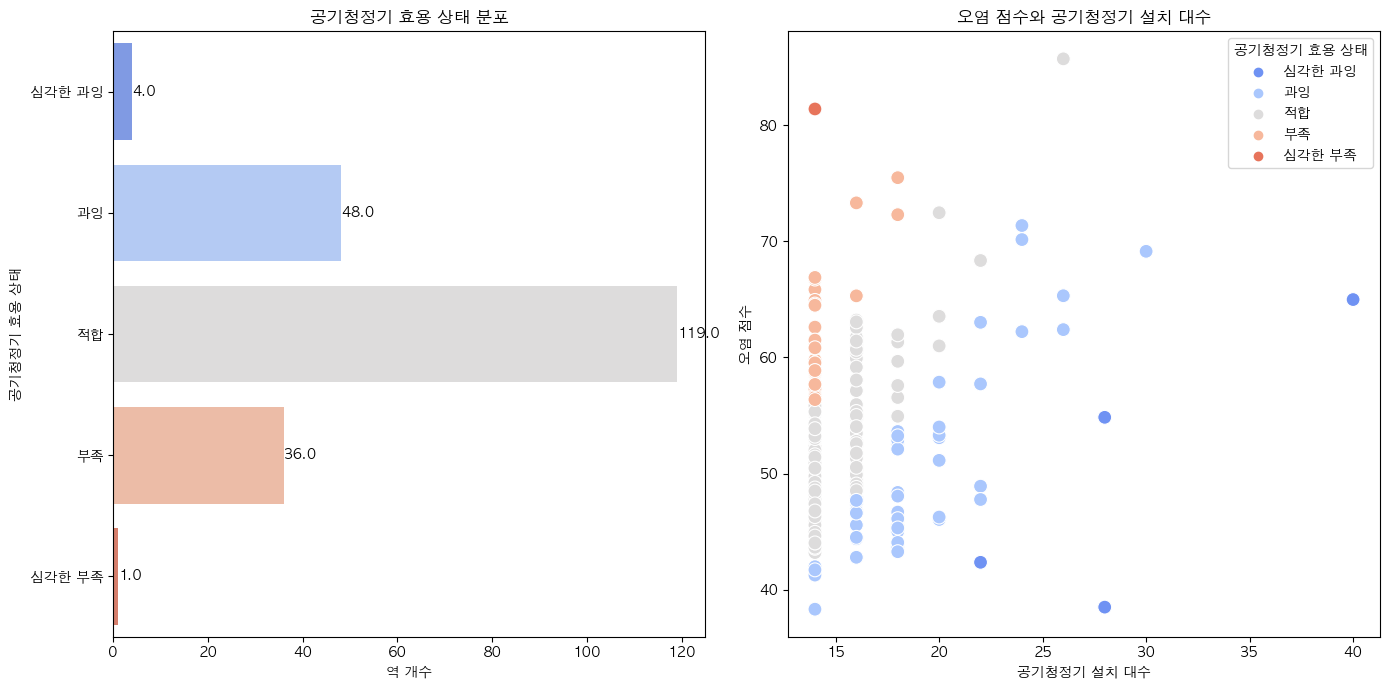

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import font_manager, rc

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
file_path = '공기청정기_효용상태.csv'
data = pd.read_csv(file_path)

# 색상 설정 (coolwarm 컬러맵의 색상 순서 반대로 적용)
colors = sns.color_palette("coolwarm", 5).as_hex()
hue_order = ['심각한 과잉', '과잉', '적합', '부족', '심각한 부족']
cmap = ListedColormap(colors)

# 시각화
plt.figure(figsize=(14, 7))

# 공기청정기 효용 상태 막대 그래프
plt.subplot(1, 2, 1)
ax = sns.countplot(y='공기청정기_효용_상태', data=data, order=hue_order, palette=colors)
plt.title('공기청정기 효용 상태 분포')
plt.xlabel('역 개수')
plt.ylabel('공기청정기 효용 상태')
# 막대 위에 개수 표시
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width() + 0.1, p.get_y() + p.get_height() / 2), va='center')

# 오염 점수와 공기청정기 설치 대수 산점도
plt.subplot(1, 2, 2)
scatter_ax = sns.scatterplot(x='설치대수', y='오염_점수', hue='공기청정기_효용_상태', data=data, palette=colors, s=100, hue_order=hue_order)
plt.title('오염 점수와 공기청정기 설치 대수')
plt.xlabel('공기청정기 설치 대수')
plt.ylabel('오염 점수')

# Legend 설정
handles, labels = scatter_ax.get_legend_handles_labels()
plt.legend(handles=handles, title='공기청정기 효용 상태', loc='upper right', labels=hue_order)

plt.tight_layout()
plt.savefig('공기청정기_효용_상태_시각화.png', dpi=300)
plt.show()
